In [1]:
import torch
import numpy as np
import torch.utils.data
from utils import dataloader
from models.casenet import casenet101 as CaseNet101
import os
import cv2
import tqdm

import argparse

import argparse
import os
import random
import shutil
import time
import warnings
import math
import numpy as np
from PIL import ImageOps, Image
import pprint
import tempfile

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt


#############################################
# This is code to generate our test dataset
# 
# We take the list of Imagenet-R classes, sort the list, and 
# take 100/200 of them by going through it with stride 2.
# 
# This is how our distorted dataset is made, so these classes should match the 
# classes used for trainig and the classes used for eval.
#############################################

# 200 classes used in ImageNet-R
imagenet_r_wnids = ['n01443537', 'n01484850', 'n01494475', 'n01498041', 'n01514859', 'n01518878', 'n01531178', 'n01534433', 'n01614925', 'n01616318', 'n01630670', 'n01632777', 'n01644373', 'n01677366', 'n01694178', 'n01748264', 'n01770393', 'n01774750', 'n01784675', 'n01806143', 'n01820546', 'n01833805', 'n01843383', 'n01847000', 'n01855672', 'n01860187', 'n01882714', 'n01910747', 'n01944390', 'n01983481', 'n01986214', 'n02007558', 'n02009912', 'n02051845', 'n02056570', 'n02066245', 'n02071294', 'n02077923', 'n02085620', 'n02086240', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02091032', 'n02091134', 'n02092339', 'n02094433', 'n02096585', 'n02097298', 'n02098286', 'n02099601', 'n02099712', 'n02102318', 'n02106030', 'n02106166', 'n02106550', 'n02106662', 'n02108089', 'n02108915', 'n02109525', 'n02110185', 'n02110341', 'n02110958', 'n02112018', 'n02112137', 'n02113023', 'n02113624', 'n02113799', 'n02114367', 'n02117135', 'n02119022', 'n02123045', 'n02128385', 'n02128757', 'n02129165', 'n02129604', 'n02130308', 'n02134084', 'n02138441', 'n02165456', 'n02190166', 'n02206856', 'n02219486', 'n02226429', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02317335', 'n02325366', 'n02346627', 'n02356798', 'n02363005', 'n02364673', 'n02391049', 'n02395406', 'n02398521', 'n02410509', 'n02423022', 'n02437616', 'n02445715', 'n02447366', 'n02480495', 'n02480855', 'n02481823', 'n02483362', 'n02486410', 'n02510455', 'n02526121', 'n02607072', 'n02655020', 'n02672831', 'n02701002', 'n02749479', 'n02769748', 'n02793495', 'n02797295', 'n02802426', 'n02808440', 'n02814860', 'n02823750', 'n02841315', 'n02843684', 'n02883205', 'n02906734', 'n02909870', 'n02939185', 'n02948072', 'n02950826', 'n02951358', 'n02966193', 'n02980441', 'n02992529', 'n03124170', 'n03272010', 'n03345487', 'n03372029', 'n03424325', 'n03452741', 'n03467068', 'n03481172', 'n03494278', 'n03495258', 'n03498962', 'n03594945', 'n03602883', 'n03630383', 'n03649909', 'n03676483', 'n03710193', 'n03773504', 'n03775071', 'n03888257', 'n03930630', 'n03947888', 'n04086273', 'n04118538', 'n04133789', 'n04141076', 'n04146614', 'n04147183', 'n04192698', 'n04254680', 'n04266014', 'n04275548', 'n04310018', 'n04325704', 'n04347754', 'n04389033', 'n04409515', 'n04465501', 'n04487394', 'n04522168', 'n04536866', 'n04552348', 'n04591713', 'n07614500', 'n07693725', 'n07695742', 'n07697313', 'n07697537', 'n07714571', 'n07714990', 'n07718472', 'n07720875', 'n07734744', 'n07742313', 'n07745940', 'n07749582', 'n07753275', 'n07753592', 'n07768694', 'n07873807', 'n07880968', 'n07920052', 'n09472597', 'n09835506', 'n10565667', 'n12267677']
imagenet_r_wnids.sort()
classes_chosen = imagenet_r_wnids[::2] # Choose 100 classes for our dataset
assert len(classes_chosen) == 100

In [94]:
imagenet_path = "/var/tmp/namespace/hendrycks/imagenet/train"

class ImageNetSubsetDataset(datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):
        
        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            assert os.path.isdir(orig_dir)

            os.symlink(orig_dir, os.path.join(self.new_root, _class))
        
        super().__init__(self.new_root, *args, **kwargs)
    
    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)


val_transforms = [
    transforms.Resize(256),
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     ),
]

val_dset = ImageNetSubsetDataset(
    imagenet_path,
    transform=transforms.Compose(val_transforms)
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_dset,
    batch_size=1,
    shuffle=True
)

Using 100 classes ['n01443537', 'n01494475', 'n01514859', 'n01531178', 'n01614925', 'n01630670', 'n01644373', 'n01694178', 'n01770393', 'n01784675', 'n01820546', 'n01843383', 'n01855672', 'n01882714', 'n01944390', 'n01986214', 'n02009912', 'n02056570', 'n02071294', 'n02085620', 'n02088094', 'n02088364', 'n02091032', 'n02092339', 'n02096585', 'n02098286', 'n02099712', 'n02106030', 'n02106550', 'n02108089', 'n02109525', 'n02110341', 'n02112018', 'n02113023', 'n02113799', 'n02117135', 'n02123045', 'n02128757', 'n02129604', 'n02134084', 'n02165456', 'n02206856', 'n02226429', 'n02236044', 'n02279972', 'n02325366', 'n02356798', 'n02364673', 'n02395406', 'n02410509', 'n02437616', 'n02447366', 'n02480855', 'n02483362', 'n02510455', 'n02607072', 'n02672831', 'n02749479', 'n02793495', 'n02802426', 'n02814860', 'n02841315', 'n02883205', 'n02909870', 'n02948072', 'n02951358', 'n02980441', 'n03124170', 'n03345487', 'n03424325', 'n03467068', 'n03494278', 'n03498962', 'n03602883', 'n03649909', 'n0371

In [165]:
def show_image(img, plt):
    if img.shape[0] == 1:
        img = img.squeeze(0)
    else:
        img = img.permute((1, 2, 0))
    plt.imshow(img, interpolation='nearest')

def do_test_sbd(net_, val_data_loader_, num_to_test = 1):
    print('Running Inference....')
    net_.eval()
    
    # define plots to show data 
    fig, ax = plt.subplots(num_to_test,2)
    fig.subplots_adjust(wspace=0.025, hspace=0.02)
    fig.set_size_inches(30, 60)

    c = 0
    for i_batch, (input_img, label) in enumerate(val_data_loader_):

        
        if label.item() != 4:
            continue
        
        im = input_img.cuda() * 255
        # print(im.shape)
        im[0][0] = im[0][0] - [104.008, 116.669, 122.675][0]
        im[0][1] = im[0][1] - [104.008, 116.669, 122.675][1]
        im[0][2] = im[0][2] - [104.008, 116.669, 122.675][2]
        # print(im)

        out_masks = net_(im)

        prediction = torch.sigmoid(out_masks[0])
                
        # Show images
        edges, _ = torch.max(prediction, dim=1, keepdim=False)
        # edges = prediction[0,2].unsqueeze(0)
        
        # print(edges.shape)
        # print(input_img.shape)
        
        show_image(edges.cpu().detach(), ax[c][0])
        show_image(input_img.squeeze(0).cpu().detach(), ax[c][1])
        
        if c + 1 >= num_to_test:
            break
        
        c += 1


In [166]:
net = CaseNet101()
net = torch.nn.DataParallel(net.cuda())

ckpt = './checkpoints/sbd/model_checkpoint.pt'
print('loading ckpt :%s' % ckpt)
net.load_state_dict(torch.load(ckpt), strict=True)

Assuming Classical SBD CASENET
loading ckpt :./checkpoints/sbd/model_checkpoint.pt


<All keys matched successfully>

Running Inference....


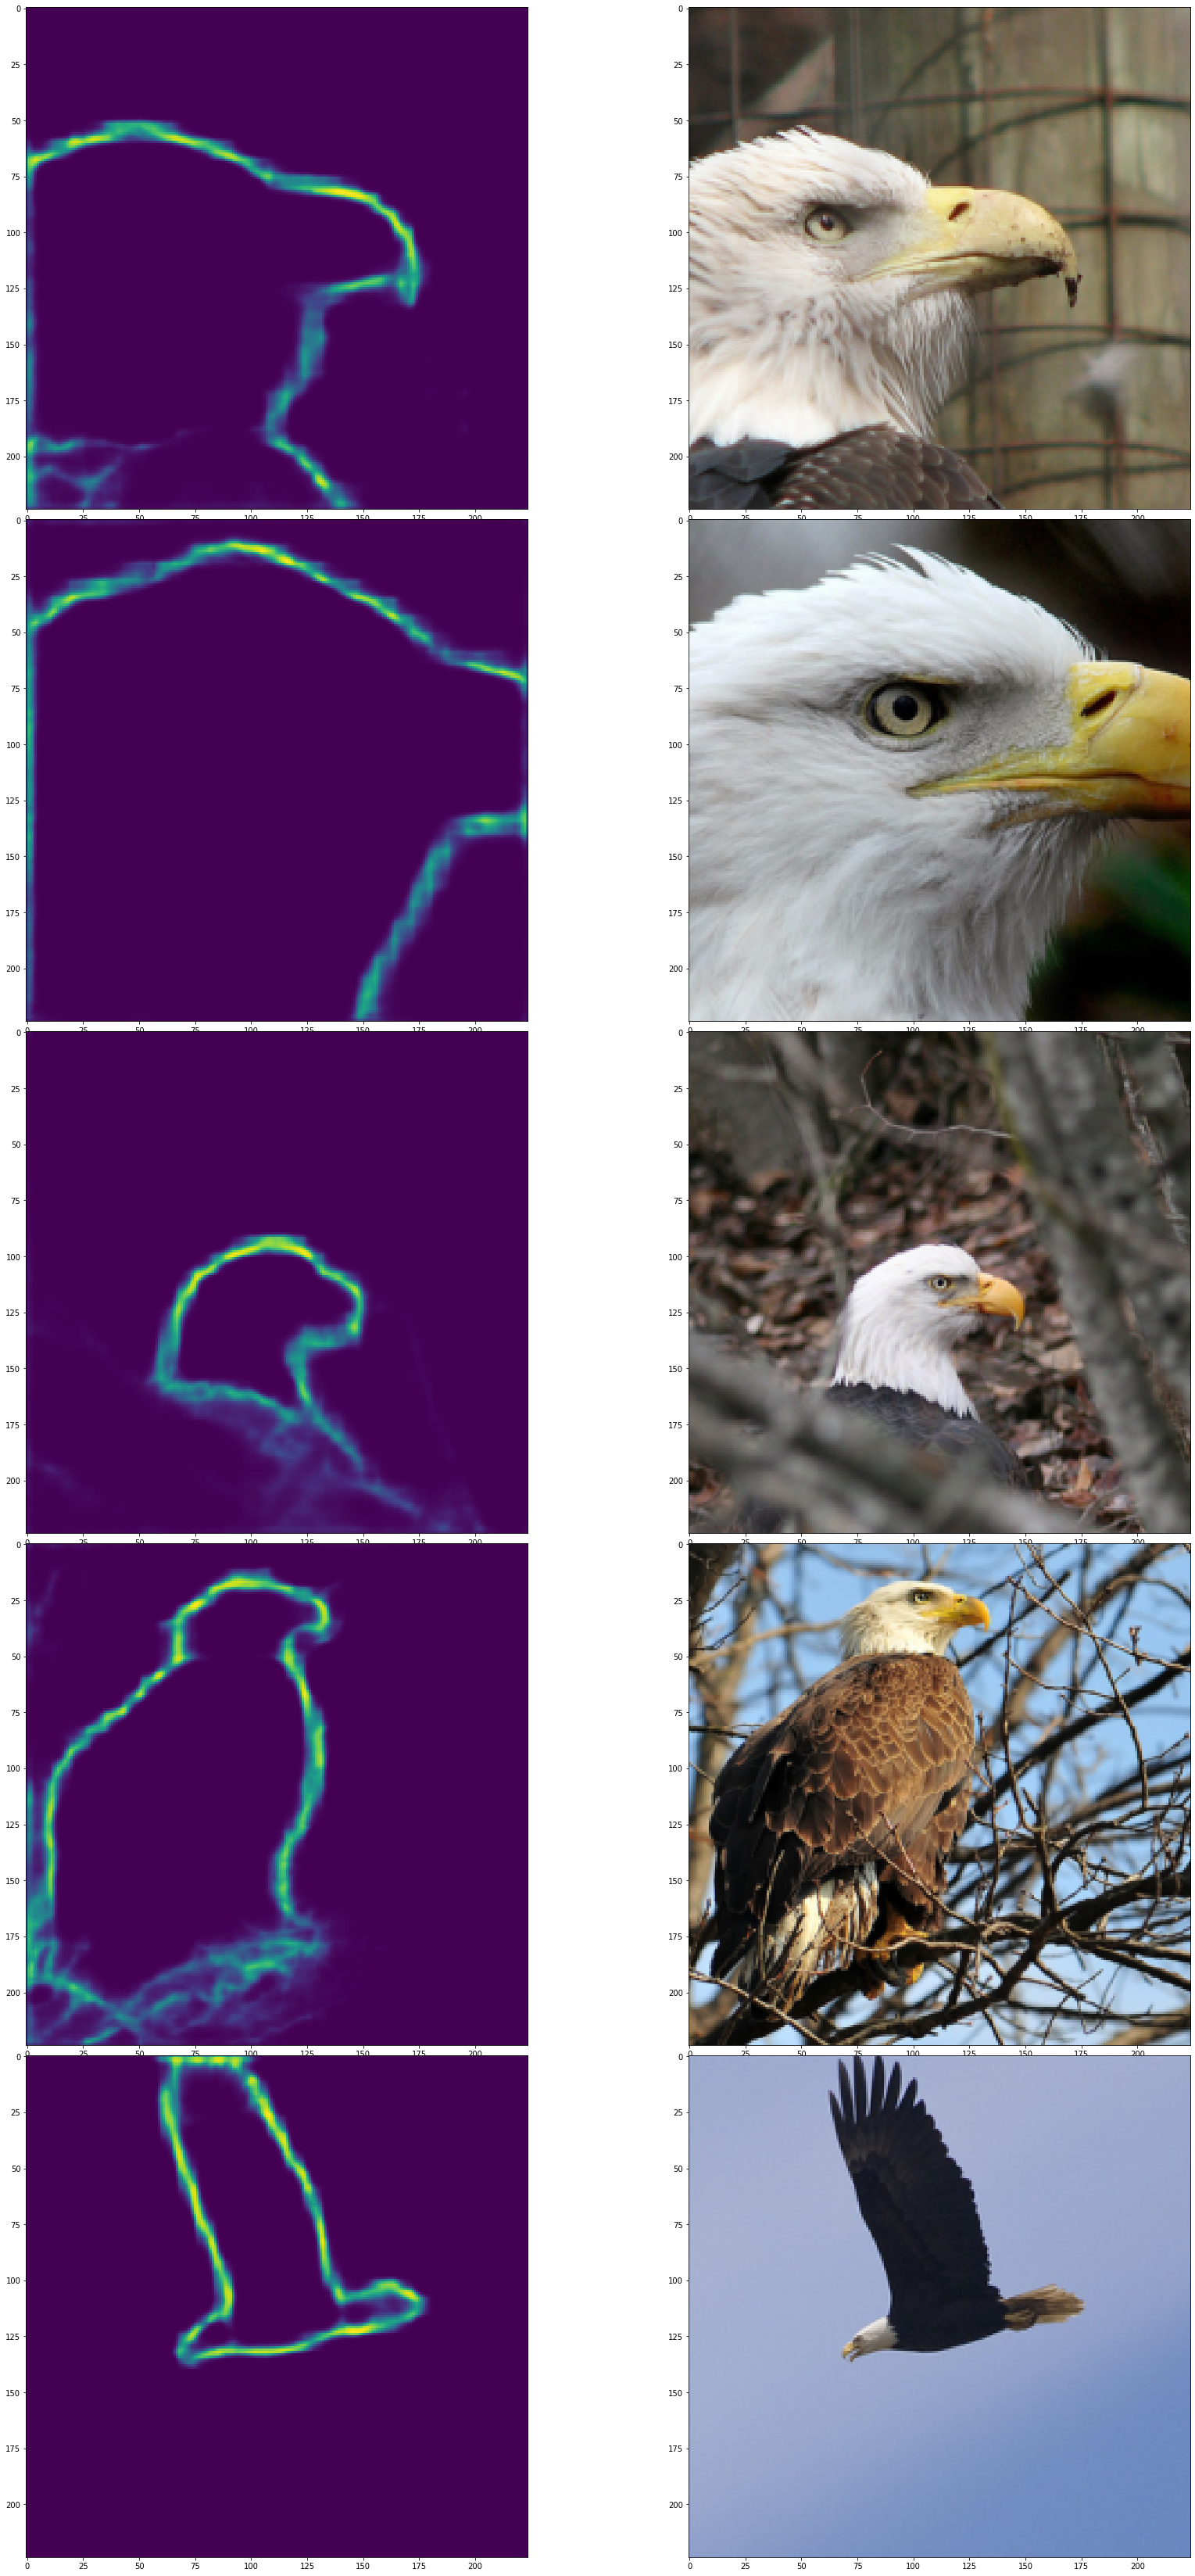

In [167]:
do_test_sbd(net, val_loader, num_to_test=5)